In [57]:
import os
import sys
import torch
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import math
import wandb
import yaml
import zarr
from scipy.fft import rfft
import seaborn as sns
from scipy import stats


os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from lab_scripts.constellation_diagram import QPSK_Constellation
from lab_scripts.constellation_diagram import RingShapedConstellation

if wandb.run is not None:
    wandb.run.tags = list(wandb.run.tags) + ["junk"]
wandb.finish()

In [58]:
'''
Import and cache dataset for fast loading in future
'''

# file_path = "C:/Users/maild/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-15MHz_3.5V_scale2.zarr"
file_path = r"C:\Users\maild\mldrivenpeled\data\channel_measurements\zarr_files\channel_3e5-15MHz_2.9V_scale2_dynamic_power_0.5-3.zarr"
# file_path = "C:/Users/maild/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-15MHz_2.8V_scale2_v2.zarr"
# file_path = "C:/Users/maild/mldrivenpeled/data/channel_measurements/zarr_files/test/channel_3e5-8MHz_2.6V_scale2_v2.zarr"

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps") # for M chip Macs
else:
    device = torch.device("cpu")
print("Device", device)
FREQUENCIES = None

cache_path = file_path.replace(".zarr", "_cached.pt").replace(".h5", "_cached.pt")
if os.path.exists(cache_path):
    data = torch.load(cache_path, map_location=device)
    sent_frames_time = data["sent_frames_time"].to(device)
    received_frames_time = data["received_frames_time"].to(device)
    FREQUENCIES = data["frequencies"].to(device)
    NUM_POINTS_SYMBOL = data["NUM_POINTS_SYMBOL"]
    CP_LENGTH = data["CP_LENGTH"]
    delta_f = FREQUENCIES[1] - FREQUENCIES[0]
    KS = (FREQUENCIES / delta_f).to(torch.int)
    K_MIN = int(KS[0].item())
    K_MAX = int(KS[-1].item())
    NUM_ZEROS = K_MIN - 1
    CP_RATIO = 0.25 # Known from experiment
    NUM_POINTS_FRAME = NUM_POINTS_SYMBOL - CP_LENGTH
    NUM_POS_FREQS_LOW_BAND = K_MAX + 1
    UPSAMPLING_ZEROS = (NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND) // 2
    print("Loaded from cache!")

else:
    print("No cache found — loading original dataset...")


        # Open the Zarr root
    root = zarr.open(file_path, mode="r")

    # Load metadata (attributes live under .attrs)
    sent, received, received_time = [], [], []
    # Loop through frames
    num_skipped = 0
    for frame_key in root.group_keys():
        try:
            frame = root[frame_key]
            if FREQUENCIES is None:
                FREQUENCIES = torch.tensor(frame["freqs"][:], dtype=torch.int).real
                NUM_POINTS_SYMBOL = int(frame.attrs["num_points_symbol"])
                CP_LENGTH = int(frame.attrs["cp_length"])
            else:
                pass

            sent.append(torch.tensor(frame["sent"][:], dtype=torch.complex64))
            received.append(torch.tensor(frame["received"][:], dtype=torch.complex64))
            if "received_time" in frame:
                received_time.append(torch.tensor(frame["received_time"][:], dtype=torch.float32))
        except:
            num_skipped += 1
            pass # skip corrupted frames
    print(f"Skipped {num_skipped} corrupted frames")


    sent_frames = torch.stack(sent).squeeze(1)
    received_frames = torch.stack(received).squeeze(1)

    # Establish globals
    delta_f = FREQUENCIES[1] - FREQUENCIES[0]
    KS = (FREQUENCIES / delta_f).to(torch.int)
    K_MIN = int(KS[0].item())
    K_MAX = int(KS[-1].item())
    NUM_ZEROS = K_MIN - 1
    CP_RATIO = 0.25
    NUM_POINTS_FRAME = NUM_POINTS_SYMBOL - CP_LENGTH
    NUM_POS_FREQS_LOW_BAND = K_MAX + 1
    UPSAMPLING_ZEROS = (NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND) // 2


    def symbols_to_time(X, num_padding_zeros: int, num_leading_zeros=0, negative_rail=-3.0, positive_rail=3.0):
        'Convert OFDM symbols to real valued signal'
        # Make hermetian symmetric
        Nt, Nf = X.shape
        padding_zeros = torch.zeros(Nt, num_padding_zeros, device=device)
        leading_zeros = torch.zeros(Nt, num_leading_zeros, device=device)
        X = torch.cat([leading_zeros, X.to(device), padding_zeros], dim=-1)
        DC_Nyquist = torch.zeros((X.shape[0], 1), device=X.device)
        X_hermitian = torch.flip(X, dims=[1]).conj()
        X_full = torch.hstack([DC_Nyquist, X, DC_Nyquist, X_hermitian])

        # Convert to time domain
        x_time = torch.fft.ifft(X_full, dim=-1, norm="ortho").real
        x_time = torch.clip(x_time, min=negative_rail, max=positive_rail)
        return x_time.to(device)





    # Handle received time symbols; perform some cleaning if necessary
    N_shortest = min(t.size(-1) for t in received_time)
    N_longest = max(t.size(-1) for t in received_time)
    good_indices = [i for i, x in enumerate(received_time) if x.size(-1) == N_shortest]
    received_frames_time = torch.stack([t for t in received_time if t.size(-1) == N_shortest], dim=0).real
    sent_frames = sent_frames[good_indices]
    received_frames_time = received_frames_time.squeeze(1)


    sent_frames_time = symbols_to_time(sent_frames, UPSAMPLING_ZEROS, NUM_ZEROS)
    # Add cyclic prefix
    sent_frames_time = torch.hstack((sent_frames_time[:, -CP_LENGTH:], sent_frames_time))



    DELAY_TIME = 0 # If for some reason there is a global delay with measure data adjust here
    if DELAY_TIME > 0:
        sent_frames_time = sent_frames_time[:, :-DELAY_TIME]
    received_frames_time = received_frames_time[:, DELAY_TIME:]
    received_frames_time = received_frames_time - received_frames_time.mean(dim=1, keepdim=True) # Always zero mean
    sent_frames_time = sent_frames_time.to(device)
    received_frames_time = received_frames_time.to(device)


    # Create a cache path
    cache_path = file_path.replace(".zarr", "_cached.pt").replace(".h5", "_cached.pt")

    torch.save({
        "sent_frames_time": sent_frames_time.cpu(),
        "received_frames_time": received_frames_time.cpu(),
        "frequencies": FREQUENCIES.cpu(),
        "NUM_POINTS_SYMBOL": NUM_POINTS_SYMBOL,
        "CP_LENGTH": CP_LENGTH
    }, cache_path)


class ChannelData(Dataset):
    def __init__(self,
                sent_frames,
                received_frames,
                frequencies,
                transform=None,
                target_transform=None):

        self.sent_frames = sent_frames
        self.received_frames = received_frames
        assert len(sent_frames) == len(received_frames)

    def __len__(self):
        return len(self.sent_frames)

    def __getitem__(self, idx):
        return self.sent_frames[idx], self.received_frames[idx]


dataset = ChannelData(sent_frames_time, received_frames_time, FREQUENCIES)

# Split sizes
train_size = int(0.9 * len(dataset))

val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

# Perform split
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator()
)
print("Train Size", train_size)

Device cuda
No cache found — loading original dataset...
Skipped 0 corrupted frames
Train Size 6388


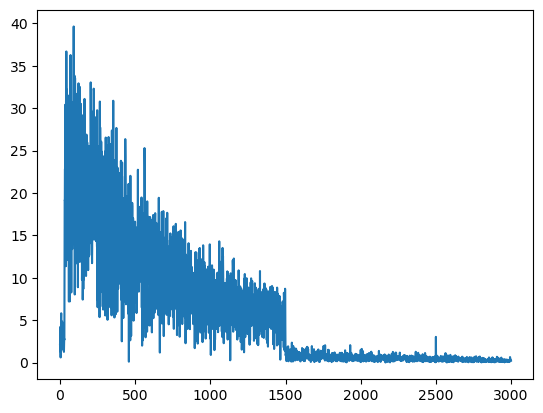

In [59]:
t = torch.fft.fft(received_frames_time[0, CP_LENGTH:].cpu()).abs()
plt.plot(t[:len(t)//2])

In [60]:
sent_frames_time.shape

torch.Size([7098, 8000])

In [61]:
received_frames_time.shape

torch.Size([7098, 8000])

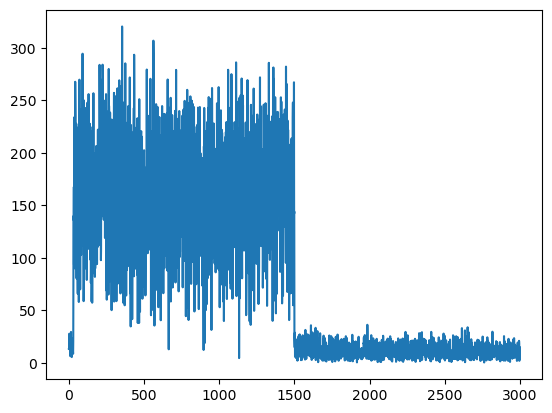

In [62]:
t = torch.fft.fft(sent_frames_time[0, CP_LENGTH:].cpu()).abs()
plt.plot(t[:len(t)//2])

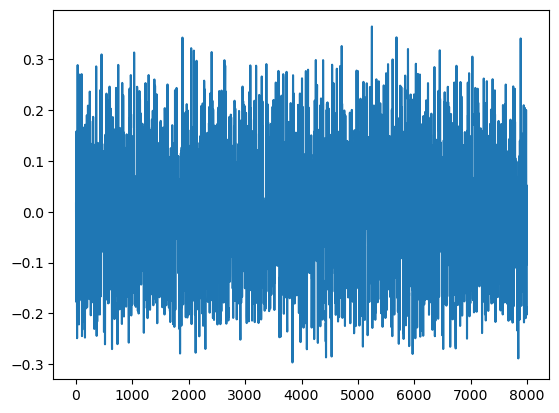

In [63]:
r = received_frames_time.cpu().numpy()
plt.plot(r[0, :])

In [64]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=0
        )
        self.padding = (kernel_size - 1) * dilation
        self.relu = nn.ReLU()
        self.resample = None
        if in_channels != out_channels:
            self.resample = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = F.pad(x, (self.padding, 0))
        out = self.conv(out)
        out = self.relu(out)
        if self.resample:
            x = self.resample(x)
        return out + x # residual connection


def sample_student_t_mps(mean, std, nu):
    '''
    Wilson-Hilferty Approximation for chi^2 converted to scaled and shifted student t
    '''
    z = torch.randn_like(mean)
    z_chi = torch.randn_like(mean)
    chi2_approx = nu * (1 - 2/(9*nu) + z_chi * torch.sqrt(2/(9*nu))).pow(3)
    scale = torch.sqrt(nu / (chi2_approx + 1e-6))
    return mean + std * z * scale


class TCN(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10, hidden_channels=32):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.tcn = nn.Sequential(*layers)
        self.readout = nn.Conv1d(hidden_channels, 1, kernel_size=1)

        # Calculate the total receptive field for the whole TCN stack
        self.receptive_field = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            self.receptive_field += (num_taps - 1) * dilation

    def forward(self, xin):
        x = xin.unsqueeze(1)    # [B,1,T]
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out).squeeze(1)
        out = out - out.mean(dim=1, keepdim=True)  # [B,T]
        return out
    

class TCN_channel(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10,
                 hidden_channels=32, learn_noise=False, gaussian=True):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.learn_noise = learn_noise
        self.tcn = nn.Sequential(*layers)
        if gaussian:
            self.readout = nn.Conv1d(hidden_channels, 2, kernel_size=1) # 2 channels mean | std
        else:
            self.readout = nn.Conv1d(hidden_channels, 3, kernel_size=1) # 3 channels mean | std | nu
        self.num_taps = num_taps
        self.gaussian = gaussian

        if not gaussian:
            with torch.no_grad():
                # Initialize nu bias towards Gaussian for stability
                self.readout.bias[2].fill_(48)

    def forward(self, xin):
        x = xin.unsqueeze(1)    # [B,1,T]
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out) # [B, 3, T] mean | std | nu
        mean_out = out[:, 0, :]
        log_std_out = out[:, 1, :]
        std_out = torch.exp(log_std_out)
        if not self.gaussian:
            log_nu_out = out[:, 2, :]
            nu_out = torch.nn.functional.softplus(log_nu_out)
            nu_out = torch.clamp(nu_out, 2, 50) # nu between 2 and 50
        mean_out = mean_out - mean_out.mean(dim=1, keepdim=True)  # [B ,T]

        # # Produce noisy output
        if self.gaussian:
            z = torch.randn_like(mean_out)
            noisy_out = mean_out + std_out * z
            nu_out = torch.zeros_like(mean_out)
        else:
            noisy_out = sample_student_t_mps(mean_out, std_out, nu_out)
            
        if self.learn_noise:
            return noisy_out, mean_out, std_out, nu_out
        else:
            return mean_out

In [65]:
def train(model, optimizer, loss_fn, loop):
    model.train()
    total_loss = 0
    batch_count = 0
    thetas = []
    for batch in loop:
        x, y = batch[0], batch[1]
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        noisy_y_pred, y_pred, y_pred_std, y_pred_nu = model(x)

        # calculate residual
        r = y - y_pred

        if model.learn_noise:
            if model.gaussian:
                loss = loss_fn(r, y_pred_std)
            else:
                loss = loss_fn(r, y_pred_std, y_pred_nu)
        else:
            loss = loss_fn(y, y_pred)

        mse_loss = F.mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        wandb.log({"nnl_train_loss": loss.item()})
        wandb.log({"mse_train_loss": mse_loss.item()})
        lr = optimizer.param_groups[0]["lr"]
        wandb.log({"learning_rate": lr})
        batch_count += 1
        loop.set_postfix(loss=loss.item())
    loop.close()


def val(model, loss_fn, val_loader):
    model.eval()
    val_loss = 0
    batch_count = 0
    y_preds = []
    std_preds = []
    nu_preds = []
    true_ys = []
    noisy_ys = []
    val_mse_loss = 0
    nrmse_pct_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            noisy_y, mean_y, std_y, nu_y = model(x)
            y_preds.append(mean_y)
            std_preds.append(std_y)
            nu_preds.append(nu_y)
            true_ys.append(y)
            noisy_ys.append(noisy_y)
            if model.learn_noise:
                if model.gaussian:
                    loss = loss_fn(y - mean_y, std_y) # Use mean for validation
                else:
                    loss = loss_fn(y - mean_y, std_y, nu_y) # Use mean for validation
            else:
                loss = loss_fn(y, mean_y)
            r = y - mean_y
            mse_loss = F.mse_loss(y, mean_y)
            nrmse_pct_loss += (torch.sqrt(torch.mean(r ** 2) / torch.mean(y ** 2)) * 100).item()
            val_mse_loss += mse_loss.item()
            val_loss += loss.item()
            batch_count += 1
    avg_val_loss = (val_loss / batch_count)
    avg_val_mse_loss = (val_mse_loss / batch_count)
    avg_nrmse_pct_loss = (nrmse_pct_loss / batch_count)

    y_preds = torch.vstack(y_preds)
    std_preds = torch.vstack(std_preds)
    nu_preds = torch.vstack(nu_preds)
    true_ys = torch.vstack(true_ys)
    noisy_ys = torch.vstack(noisy_ys)


    noise_pred = noisy_ys - y_preds
    noise_power_pred_k = torch.fft.fft(noise_pred[:, CP_LENGTH:], norm='ortho', dim=-1).abs().square().mean(dim=0)
    signal_power_model = torch.fft.fft(y_preds[:, CP_LENGTH:], norm='ortho', dim=-1).abs().square().mean(dim=0)
    snr_k_model = (signal_power_model / (noise_power_pred_k + 1e-8))
    sample_rate = delta_f * NUM_POINTS_FRAME
    snr_mag_model = 10 * torch.log10(torch.abs(snr_k_model) + 1e-8)
    freqs = torch.fft.fftfreq(len(snr_mag_model), d=1/sample_rate)
    half = len(freqs)//2
    freqs = freqs[:half]
    snr_mag_model = snr_mag_model[:half]
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(freqs, snr_mag_model.cpu(), lw=1.5, color="orange")
    ax.set_title("SNR vs Frequency (Model)", fontsize=11)
    ax.set_xlabel("Frequency", fontsize=9)
    ax.set_ylabel("SNR Magnitude (dB)", fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.6)
    # # ---- Log to WandB ----
    wandb.log({"SNR_Frequency": wandb.Image(fig)})
    plt.close(fig)


    # Log both scalar and histogram
    wandb.log({
        'val_nll_loss': avg_val_loss,
        "avg_val_mse_loss": avg_val_mse_loss,
        "avg_nrmse_pct_loss": avg_nrmse_pct_loss
    })

    # print(f"Average Val Loss: {avg_val_loss:.2e}")

    # visualize_std(model, x[:, :200])
    return avg_val_loss


In [66]:
def students_t_loss(difference, y_pred_std, y_pred_nu):
    # nu = y_pred_nu.clamp_min(2.0)
    nu = y_pred_nu
    z_resid = (difference) / (y_pred_std)
    term1 = -1 * torch.lgamma((nu + 1) / 2) + 0.5 * torch.log(torch.pi * nu) + torch.lgamma(nu / 2) + torch.log(y_pred_std + 1e-8)
    term2 = ((nu + 1) / 2) * torch.log(1 + (1 / nu) * torch.square(z_resid) + 1e-8)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss

def gaussian_nll(difference, y_pred_std):
    term1 = 0.5 * torch.log(2 * torch.pi * (y_pred_std ** 2))
    term2 = 0.5 * torch.square((difference) / y_pred_std)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss

noise_model = None

def make_optimizer(mode):
    if mode == "channel_only":
        return optim.AdamW(
            list(channel_model.parameters()),
            lr=float(config.lr_channel),
            weight_decay=float(config.wd_channel)
        )

    elif mode == "noise_only":
        return optim.AdamW(
            list(noise_model.parameters()),
            lr=float(config.lr_noise),
            weight_decay=float(config.wd_noise)
        )

    elif mode == "joint":
        return optim.AdamW(
            list(channel_model.parameters()) +
            list(noise_model.parameters()),
            lr=float(config.lr_joint),
            weight_decay=float(config.wd_joint)
        )
    else:
        raise ValueError("Unknown mode")


script_dir = os.getcwd()
config_path = os.path.join(script_dir, "..", "offline_time_channel_config.yml")
with open(config_path, "r") as f:
    hyperparams = yaml.safe_load(f)

# Start Weights and Biases session
wandb.init(project="mldrivenpeled",
           config=hyperparams, tags=['channel_model'])
config = wandb.config

schedule = config.training_schedule


RECEPTIVE_FIELD = (1 + (config.num_taps - 1) * (config.dilation_base**config.nlayers - 1) // (config.dilation_base - 1))


print(f"WandB run info:")
print(f"  Name: {wandb.run.name}")
print(f"  ID: {wandb.run.id}")
print(f"  URL: {wandb.run.url}")
print("Chosen hyperparameters for this session:")
print(config)


# Create dataloader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=config.batch_size, drop_last=False)
test_loader = DataLoader(test_dataset)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=config.batch_size, drop_last=False)


channel_model = TCN_channel(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels,
    learn_noise=config.learn_noise,
    gaussian=config.gaussian
).to(device)

initial_model_state = copy.deepcopy(channel_model.state_dict())

if channel_model.gaussian:
    loss_fn = gaussian_nll
else:
    loss_fn = students_t_loss

# loss_fn = F.mse_loss

num_epochs = config.epochs

epoch_counter = 0
for phase in schedule:
    mode = phase["mode"]
    num_batches = None # if None, all batches run
    if "batches" in phase:
        num_batches = phase["batches"]
    num_phase_epochs = phase["epochs"]


    optimizer = make_optimizer(mode)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)

    for local_epoch in range(num_phase_epochs):
        epoch_counter += 1

        loop = tqdm(train_loader, desc=f'Epoch {epoch_counter} [{mode}]')
        train(channel_model,
              optimizer,
              loss_fn,
              loop)

        avg_val_loss = val(channel_model,
                           loss_fn,
                           val_loader)

        scheduler.step(avg_val_loss)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(channel_model):,}")
# Freeze model
for param in channel_model.parameters():
    param.requires_grad = False

# Save model
torch.save({
    "channel_model": channel_model.state_dict(),
}, "channel_model_final.pth")

artifact = wandb.Artifact("channel_model", type="model")
artifact.add_file("channel_model_final.pth")
logged_artifact = wandb.log_artifact(artifact)

# Get version from server for next stage
logged_artifact.wait()

channel_model_version = logged_artifact.version
channel_model_artifact_path = logged_artifact.name

print("Finished!")
run_name = wandb.run.name
wandb.finish()

WandB run info:
  Name: proud-energy-7885
  ID: nippsedi
  URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/runs/nippsedi
Chosen hyperparameters for this session:
{'CP_ratio': 0.25, 'batch_size': 16, 'num_taps': 10, 'epochs': 1, 'gain': 20, 'lr': 0.001, 'nlayers': 2, 'hidden_channels': 8, 'dilation_base': 2, 'num_points_symbol': 4000, 'learn_noise': True, 'num_symbols_per_frame': 1, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'gaussian': False, 'Nf': 1499, 'Nt': 1, 'flow': 300000, 'fhigh': '15e6', 'fnyquist': '30e6', 'subcarrier_spacing': '1e4', 'dc_offset': 3.5, 'lr_channel': '1e-3', 'lr_noise': '1e-3', 'lr_joint': '1e-3', 'wd_channel': '1e-3', 'wd_noise': '1e-3', 'wd_joint': '1e-4', 'training_schedule': [{'epochs': 10, 'mode': 'channel_only'}]}


Epoch 10 [channel_only]: 100%|██████████| 400/400 [00:03<00:00, 108.89it/s, loss=-3.25]


Trainable parameters: 779


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Finished!


avg_nrmse_pct_loss,█▅▃▃▂▁▃▁▃▂
avg_val_mse_loss,█▅▃▃▂▁▃▁▃▁
learning_rate,██████████████████████████████▁▁▁▁▁▁▁▁▁▁
mse_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nnl_train_loss,█▄▄▃▃▂▂▃▃▂▂▂▁▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▂
val_nll_loss,█▅▃▃▂▃▃▁▂▁
avg_nrmse_pct_loss,14.0411
avg_val_mse_loss,0.00014
learning_rate,0.0005
mse_train_loss,0.00013
nnl_train_loss,-3.25214


In [67]:
run_name

'proud-energy-7885'

### Memory Polynomial for Comparison

In [68]:


# def create_regressors(X, memory_linear, memory_nonlinear, nonlinearity_order):
#     B, T = X.shape
#     # Each example and target will get a matrix and column vector. All will be stacked
#     # to form a A with shape [NxT, memory_linear + memory_nonlinearxnonlinear_order] regressor matrix
#     batched_regressor_cols = []
#     num_regressors = memory_linear + (memory_nonlinear * (nonlinearity_order - 1)) + 2
#     regressor_length = T * B


#     for i in range(memory_linear + 1):
#         X_shifted = np.roll(X, i, axis=1)
#         X_shifted[:, :i] = 0.0
#         batched_regressor_cols.append(X_shifted)

#     for k in range(2, nonlinearity_order + 1):
#         for j in range(memory_nonlinear + 1):
#             X_shifted = np.roll(X, j, axis=1)
#             X_shifted[:, :j] = 0.0
#             batched_regressor_cols.append(np.power(X_shifted, k))

#     stack = np.array(batched_regressor_cols) # [features, B, T]
#     stack = stack.transpose(1, 2, 0) # [B, T, freatures]
#     A = stack.reshape(regressor_length, num_regressors)
#     return A

# def memory_polynomial(X, Y, memory_linear, memory_nonlinear, nonlinearity_order):
#     A = create_regressors(X, memory_linear, memory_nonlinear, nonlinearity_order)
#     Y_flat = Y.flatten()

#     weights, residuals, rank, s = np.linalg.lstsq(A, Y_flat, rcond=None)
#     # print("Solved Weights:", weights)
#     y_pred = A @ weights
#     # Reshape back to (B, T) for analysis
#     B, T = X.shape
#     y_pred = y_pred.reshape(B, T)
#     residuals = Y - y_pred
#     return weights, y_pred, residuals

    

# weights, y_pred, residuals = memory_polynomial(X, Y, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2)


# # Calculate NRMSE
# signal_power = np.mean(np.square(Y))
# error_power = np.mean(np.square(residuals))

# nrmse_pct = np.sqrt(error_power / signal_power) * 100
# print("NRMSE  %", nrmse_pct)

In [69]:
class memory_polynomial_channel(nn.Module):
    def __init__(self,
                 weights,
                memory_linear,
                memory_nonlinear,
                nonlinearity_order
                 ):
        super().__init__()
        if weights:
            self.weights = torch.tensor(weights, device=device)
        else:
            self.weights = None
        self.memory_linear = memory_linear
        self.memory_nonlinear = memory_nonlinear
        self.nonlinearity_order = nonlinearity_order

    def _create_regressors(self, X):
        B, T = X.shape
        # Each example and target will get a matrix and column vector. All will be stacked
        # to form a A with shape [NxT, memory_linear + memory_nonlinearxnonlinear_order] regressor matrix
        batched_regressor_cols = []
        num_regressors = self.memory_linear + (self.memory_nonlinear * (self.nonlinearity_order - 1)) + 2
        regressor_length = T * B
        for i in range(self.memory_linear + 1):
            X_shifted = torch.roll(X, i, dims=1)
            X_shifted[:, :i] = 0.0
            batched_regressor_cols.append(X_shifted)

        for k in range(2, self.nonlinearity_order + 1):
            for j in range(self.memory_nonlinear + 1):
                X_shifted = torch.roll(X, j, dims=1)
                X_shifted[:, :j] = 0.0
                batched_regressor_cols.append(torch.pow(X_shifted, k))

        stack = torch.stack(batched_regressor_cols) # [features, B, T]
        stack = stack.permute(1, 2, 0) # [B, T, freatures]
        A = stack.reshape(regressor_length, num_regressors)
        return A
    
    def fit(self, X, Y):
        A = self._create_regressors(X)
        Y_flat = Y.flatten()

        weights, residuals, rank, s = torch.linalg.lstsq(A, Y_flat)
        # print("Solved Weights:", weights)
        y_pred = A @ weights
        # Reshape back to (B, T) for analysis
        B, T = X.shape
        y_pred = y_pred.reshape(B, T)
        residuals = Y - y_pred
        self.weights = weights
        return weights, A, residuals

    def forward(self, X):
        A_x = self._create_regressors(X)
        B, T = X.shape
        y_pred = A_x @ self.weights
        y_pred = y_pred.reshape(B, T)
        return y_pred


In [70]:
NUM_POINTS_FRAME = 6000
CP_LENGTH = 2000
NUM_POINTS_SYMBOL = NUM_POINTS_FRAME + CP_LENGTH

TCN_CHANNEL = True
if TCN_CHANNEL:
    api = wandb.Api()
    # run = api.run("dylanbackprops-university-of-washington/mldrivenpeled/oibih492") # Variable
    model_name = "channel_model_final"
    # artifact = api.artifact("dylanbackprops-university-of-washington/mldrivenpeled/channel_model:v581") # Variable


    entity = "dylanbackprops-university-of-washington"
    project = "mldrivenpeled"
    artifact_name = "channel_model"
    version = channel_model_version

    # Construct the full path string
    channel_model_artifact_path = f"{entity}/{project}/{artifact_name}:{version}"
    artifact = api.artifact(channel_model_artifact_path)
    artifact_dir = artifact.download()

    logging_run = artifact.logged_by() 

    remote_config = logging_run.config

    run_name = logging_run.name
    print("Channel Run name:", run_name)

    channel_model = TCN_channel(
        nlayers=remote_config['nlayers'],
        dilation_base=remote_config['dilation_base'],
        num_taps=remote_config['num_taps'],
        hidden_channels=remote_config['hidden_channels'],
        learn_noise=remote_config['learn_noise'],
        gaussian=remote_config['gaussian']
    ).to(device)


    channel_model_path = os.path.join(artifact_dir, model_name + ".pth")
    checkpoint = torch.load(channel_model_path)
    channel_model.load_state_dict(checkpoint["channel_model"])
else:
    channel_model = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2)
    channel_model.fit(sent_frames_time, received_frames_time)


# Freeze before moving to device
for param in channel_model.parameters():
    param.requires_grad = False


channel_model = channel_model.to(device).float()
channel_model.eval()


wandb:   1 of 1 files downloaded.  


Channel Run name: proud-energy-7885


C:\Users\maild\AppData\Local\Temp\ipykernel_7740\543670868.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(channel_model_path)


TCN_channel(
  (tcn): Sequential(
    (0): TCNBlock(
      (conv): Conv1d(1, 8, kernel_size=(10,), stride=(1,))
      (relu): ReLU()
      (resample): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
    )
    (1): TCNBlock(
      (conv): Conv1d(8, 8, kernel_size=(10,), stride=(1,), dilation=(2,))
      (relu): ReLU()
    )
  )
  (readout): Conv1d(8, 3, kernel_size=(1,), stride=(1,))
)

In [73]:
# Average sent power 
avg_sent_pwer = sent_frames_time.square().mean().item()
print(avg_sent_pwer)

1.0436452627182007


Channel model parameters frozen: True


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


BER,▅█▆▆▅▂▄▃▁▇▆▇▅▅▅▇▅▆▇▄▅▆▅▅▆▅▄▅▅▅▇▅▄▅▅▄▆▅▅▆
freq_loss,██▆▄▁
learning_rate,█████████▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,███▇▇▁
time_frame_BER,▇▇█▇▆▁█▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇█▇▇▇███▇▇████▇▇█
time_mse_loss,████▇▇▆▆▅▅▄▃▂▂▁
BER,0.49964
freq_loss,nan
learning_rate,0.0
loss,nan
time_frame_BER,0.49964


WandB run info:
  Name: mild-dragon-7887
  ID: hof1dszm
  URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/runs/hof1dszm
Chosen hyperparameters for this session:
{'CP_ratio': 0.25, 'batch_size': 16, 'dc_offset': 0, 'num_taps': 10, 'epochs': 750, 'gain': 20, 'lr': 0.001, 'nlayers': 2, 'hidden_channels': 16, 'dilation_base': 2, 'preamble_amplitude': 3, 'num_symbols_per_frame': 1, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'Nf': 1470, 'Nt': 1, 'flow': 300000, 'fhigh': '15e6', 'subcarrier_spacing': '1e4', 'modulator': 'm7_apsk_constellation'}


C:\Users\maild\AppData\Local\Temp\ipykernel_7740\3756494747.py:274: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  true_bits_array = np.array(true_bits)


KeyboardInterrupt: 

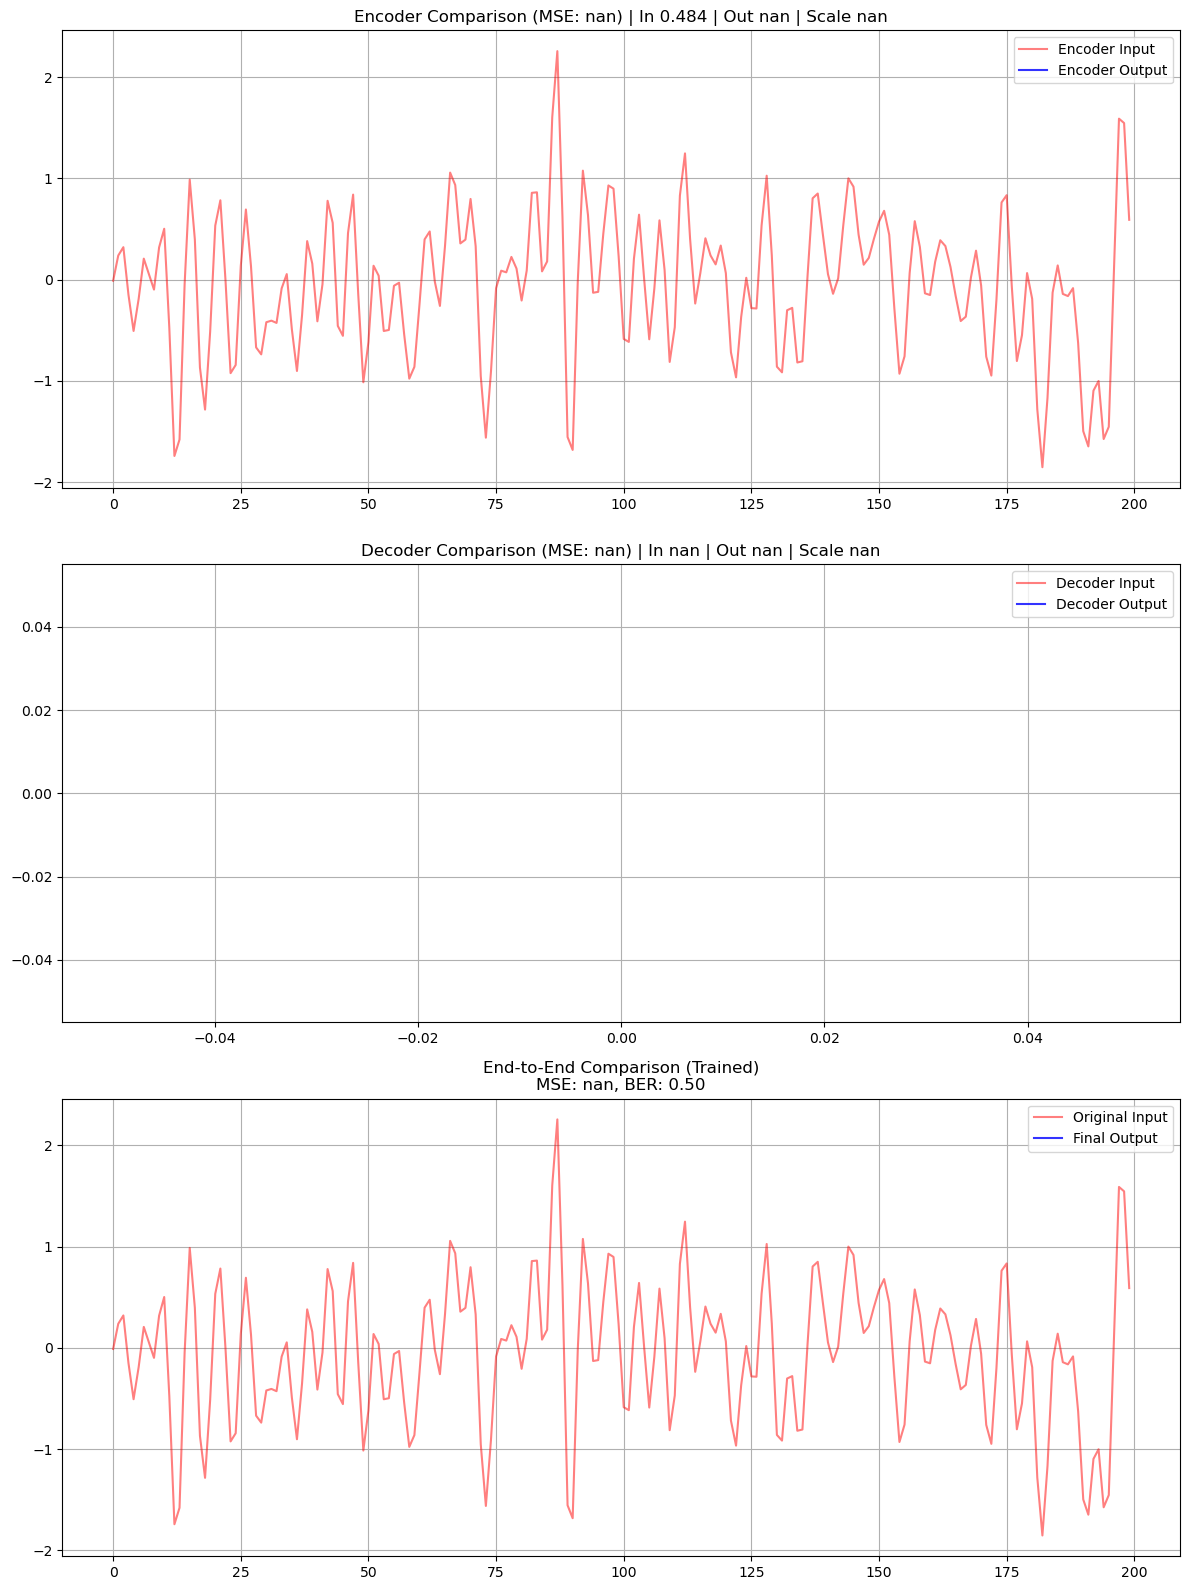

In [ ]:

print("Channel model parameters frozen:",
      all(not param.requires_grad for param in channel_model.parameters()))

constellation_mode = "m7_apsk_constellation"

def get_constellation(mode: str):
        if mode == "qpsk":
            constellation = QPSK_Constellation()
        elif mode == "m5_apsk_constellation":
            constellation = RingShapedConstellation(filename=r'/Users/dylanjones/Desktop/mldrivenpeled/lab_scripts/saved_constellations/m5_apsk_constellation.npy')
        elif mode == "m6_apsk_constellation":
             constellation = RingShapedConstellation(filename=r'/Users/dylanjones/Desktop/mldrivenpeled/lab_scripts/saved_constellations/m6_apsk_constellation.npy')
        elif mode == "m7_apsk_constellation":
             constellation = RingShapedConstellation(filename=r'C:\Users\maild\mldrivenpeled\lab_scripts\saved_constellations\m7_apsk_constellation.npy')
        return constellation

constellation = get_constellation(constellation_mode)

script_dir = os.getcwd()
config_path = os.path.join(script_dir, "..", "offline_time_ae_config.yml")
with open(config_path, "r") as f:
    hyperparams = yaml.safe_load(f)

    wandb.init(project="mldrivenpeled",
            config=hyperparams,
            tags=['autoencoder'])
    config = wandb.config
    if wandb.run.notes is None:
        wandb.run.notes = ""
    config.modulator = constellation_mode
    wandb.run.notes += wandb.run.notes + f"\n | trained on channel model {run_name} \n | {constellation_mode}"
    print("WandB run info:")
    print(f"  Name: {wandb.run.name}")
    print(f"  ID: {wandb.run.id}")
    print(f"  URL: {wandb.run.url}")
    print("Chosen hyperparameters for this session:")
    print(config)

encoder = TCN(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels,
).to(device)

decoder = TCN(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels
).to(device)

optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=config.lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-6)


NUM_BITS = config.Nt * config.Nf * constellation.modulation_order
FREQUENCIES = torch.arange(float(config.flow), float(config.fhigh), float(config.subcarrier_spacing))
delta_f = FREQUENCIES[1] - FREQUENCIES[0]
KS = (FREQUENCIES / delta_f).to(torch.int)
K_MIN = int(KS[0].item())
K_MAX = int(KS[-1].item())
NUM_ZEROS = K_MIN - 1
UPSAMPLING_ZEROS= (NUM_POINTS_FRAME  +  -2 * K_MIN + -2 * len(KS)) // 2
PREAMBLE_MAX = config.preamble_amplitude
UPSAMPLING_ZEROS


def make_time_validate_plots(enc_in, enc_out, dec_in, dec_out,
                             frame_BER, run_model, step=0, zoom_samples=200):

    # Convert to numpy
    enc_in = enc_in.detach().cpu().numpy().flatten()
    enc_out = enc_out.detach().cpu().numpy().flatten()
    dec_in = dec_in.detach().cpu().numpy().flatten()
    dec_out = dec_out.detach().cpu().numpy().flatten()

    # Power and scaling
    enc_power_in = np.mean(enc_in**2)
    enc_power_out = np.mean(enc_out**2)
    enc_scale = enc_power_out / (enc_power_in + 1e-12)

    dec_power_in = np.mean(dec_in**2)
    dec_power_out = np.mean(dec_out**2)
    dec_scale = dec_power_out / (dec_power_in + 1e-12)

    # MSEs
    mse_encoder = np.mean((enc_in - enc_out) ** 2)
    mse_decoder = np.mean((dec_in - dec_out) ** 2)
    mse_total = np.mean((enc_in - dec_out) ** 2)

    # Log scalars
    prefix = "time_"
    wandb.log({f"{prefix}mse_loss": mse_total}, step=step)
    wandb.log({f"{prefix}frame_BER": frame_BER}, step=step)

    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(12, 16))
    time_points = np.arange(zoom_samples)

    axes[0].plot(time_points, enc_in[:zoom_samples], 'r', alpha=0.5, label='Encoder Input')
    axes[0].plot(time_points, enc_out[:zoom_samples], 'b', alpha=0.8, label='Encoder Output')
    axes[0].set_title(
        f"Encoder Comparison (MSE: {mse_encoder:.2e}) | "
        f"In {enc_power_in:.3f} | Out {enc_power_out:.3f} | Scale {enc_scale:.3f}"
    )
    axes[0].legend(); axes[0].grid(True)

    axes[1].plot(time_points, dec_in[:zoom_samples], 'r', alpha=0.5, label='Decoder Input')
    axes[1].plot(time_points, dec_out[:zoom_samples], 'b', alpha=0.8, label='Decoder Output')
    axes[1].set_title(
        f"Decoder Comparison (MSE: {mse_decoder:.2e}) | "
        f"In {dec_power_in:.3f} | Out {dec_power_out:.3f} | Scale {dec_scale:.3f}"
    )
    axes[1].legend(); axes[1].grid(True)

    axes[2].plot(time_points, enc_in[:zoom_samples], 'r', alpha=0.5, label='Original Input')
    axes[2].plot(time_points, dec_out[:zoom_samples], 'b', alpha=0.8, label='Final Output')
    axes[2].set_title(
        f"End-to-End Comparison ({'Trained' if run_model else 'Untrained'})\n"
        f"MSE: {mse_total:.2e}, BER: {frame_BER:.2f}"
    )
    axes[2].legend(); axes[2].grid(True)

    fig.tight_layout()
    wandb.log({f"{prefix}time_signals": wandb.Image(fig)}, step=step)
    plt.close(fig)


def evm_loss(true_symbols, predicted_symbols):
    return torch.mean(torch.abs(true_symbols - predicted_symbols) ** 2)

def in_band_filter(x, ks_indices, nfft):
    mask = torch.zeros(nfft, device=device)
    neg_ks_indices = nfft - ks_indices
    mask[ks_indices] = 1.0
    mask[neg_ks_indices] = 1.0

    impulse_response = torch.fft.ifftshift(torch.fft.ifft(mask).real)
    h = impulse_response.view(1, 1, -1)
    filtered_x = F.conv1d(x.unsqueeze(1), h, padding='same').squeeze(1)
    return filtered_x


def in_band_time_loss(sent_time, decoded_time, ks_indices, n_fft, num_taps):
    """Compute in-band loss directly in time domain using filtering"""
    # Create frequency mask
    mask = torch.zeros(n_fft, device=sent_time.device)
    neg_ks_indices = n_fft - ks_indices
    mask[ks_indices] = 1.0
    mask[neg_ks_indices] = 1.0

    # Convert to time-domain filter (this is differentiable)
    impulse_response = torch.fft.ifftshift(torch.fft.ifft(mask).real)
    h = impulse_response.view(1, 1, -1)

    # Filter both signals
    sent_filtered = F.conv1d(sent_time.unsqueeze(1), h, padding='same').squeeze(1)
    decoded_filtered = F.conv1d(decoded_time.unsqueeze(1), h, padding='same').squeeze(1)

    # Compute MSE on filtered signals (equivalent to in-band frequency loss)
    loss = torch.mean((sent_filtered[:, num_taps:] - decoded_filtered[:, num_taps:]).pow(2))
    return loss


def symbols_to_time(X, num_padding_zeros: int, num_leading_zeros=0):
    # Make hermetian symmetric
    Nt, Nf = X.shape
    padding_zeros = torch.zeros(Nt, num_padding_zeros, device=device)
    leading_zeros = torch.zeros(Nt, num_leading_zeros, device=device)
    X = torch.cat([leading_zeros, X.to(device), padding_zeros], dim=-1)
    DC_Nyquist = torch.zeros((X.shape[0], 1), device=X.device)
    X_hermitian = torch.flip(X, dims=[1]).conj()
    X_full = torch.hstack([DC_Nyquist, X, DC_Nyquist, X_hermitian])
    # Convert to time domain
    x_time = torch.fft.ifft(X_full, dim=-1, norm="ortho").real
    return x_time.to(device)


def add_noise_time_cp(signal_with_cp, cp_length, snr_in, snr_low, snr_high, inband_idx, print_snr=False):
    """
    Adds spectrally-shaped noise with three regions:
      - In-band: indices in inband_idx
      - Low out-of-band: below min(inband_idx)
      - High out-of-band: above max(inband_idx)
    """
    B, N_with_cp = signal_with_cp.shape
    device = signal_with_cp.device

    signal_no_cp = signal_with_cp[:, cp_length:]
    P_sig = signal_no_cp.pow(2).mean(dim=-1, keepdim=True)

    Pn_in_target = P_sig / snr_in
    Pn_low_target = P_sig / snr_low
    Pn_high_target = P_sig / snr_high

    num_pos_freqs = (N_with_cp - 1) // 2
    pos_freq_slice = slice(1, num_pos_freqs + 1)
    neg_freq_slice = slice(N_with_cp - num_pos_freqs, N_with_cp)

    inband_mask = torch.zeros(num_pos_freqs, dtype=bool, device=device)
    valid_inband_indices = inband_idx[(inband_idx > 0) & (inband_idx <= num_pos_freqs)]
    if valid_inband_indices.numel() > 0:
        inband_mask[valid_inband_indices - 1] = True

    all_idx = torch.arange(num_pos_freqs, device=device)
    low_mask = (all_idx < inband_idx.min()) & ~inband_mask
    high_mask = (all_idx > inband_idx.max()) & ~inband_mask

    num_in_bins = inband_mask.sum()
    num_low_bins = low_mask.sum()
    num_high_bins = high_mask.sum()

    def make_noise(num_bins, target_power):
        if num_bins == 0:
            return torch.zeros((B, 0), dtype=torch.complex64, device=device)
        var_per_bin = (target_power * N_with_cp) / (2 * num_bins)
        std_per_bin = torch.sqrt(var_per_bin)
        noise = (torch.randn(B, num_bins, device=device) +
                 1j * torch.randn(B, num_bins, device=device)) / math.sqrt(2.0)
        return std_per_bin * noise

    noise_in_pos = make_noise(num_in_bins, Pn_in_target)
    noise_low_pos = make_noise(num_low_bins, Pn_low_target)
    noise_high_pos = make_noise(num_high_bins, Pn_high_target)

    noise_pos = torch.zeros(B, num_pos_freqs, dtype=torch.complex64, device=device)
    if num_in_bins > 0: noise_pos[:, inband_mask] = noise_in_pos
    if num_low_bins > 0: noise_pos[:, low_mask] = noise_low_pos
    if num_high_bins > 0: noise_pos[:, high_mask] = noise_high_pos

    noise_fft = torch.zeros(B, N_with_cp, dtype=torch.complex64, device=device)
    noise_fft[:, pos_freq_slice] = noise_pos
    noise_fft[:, neg_freq_slice] = torch.conj(torch.flip(noise_pos, dims=[1]))
    noise_fft[:, 0] = 0
    noise_time = torch.fft.ifft(noise_fft, norm="ortho").real

    if print_snr:
        P_sig_mean = P_sig.mean().item()
        def check(mask, noise_vals, target):
            if mask.sum() == 0: return
            tmp_fft = torch.zeros_like(noise_fft)
            tmp_pos = torch.zeros_like(noise_pos); tmp_pos[:, mask] = noise_vals
            tmp_fft[:, pos_freq_slice] = tmp_pos
            tmp_fft[:, neg_freq_slice] = torch.conj(torch.flip(tmp_pos, dims=[1]))
            Pn_actual = torch.fft.ifft(tmp_fft, norm="ortho").real.pow(2).mean().item()
            print(f"SNR Check: target={target:.2f}, actual={P_sig_mean/Pn_actual:.2f}")
        check(inband_mask, noise_in_pos, snr_in)
        check(low_mask, noise_low_pos, snr_low)
        check(high_mask, noise_high_pos, snr_high)

    return signal_with_cp + noise_time



def calculate_BER(received_symbols, true_bits, constellation):
    # Demap symbols to bits
    constellation_symbols = torch.tensor(
        list(constellation._symbols_to_bits_map.keys()),
        dtype=received_symbols.dtype,
        device=received_symbols.device
    )
    distances = abs(received_symbols.reshape(-1, 1) - constellation_symbols.reshape(1, -1))

    closest_idx = distances.argmin(axis=1)
    constellation_symbols_list = list(constellation._symbols_to_bits_map.keys())
    decided_bits = [constellation._symbols_to_bits_map[constellation_symbols_list[idx]] for idx in closest_idx.cpu().numpy()]

    # Flatten decided bits into a 1D array
    decided_bits_flat = [int(bit) for symbol_bits in decided_bits for bit in symbol_bits]


    # Convert to NumPy arrays for comparison
    true_bits_array = np.array(true_bits)
    decided_bits_flat_array = np.array(decided_bits_flat)

    # Take minimum length to avoid shape mismatch
    min_len = min(len(true_bits_array), len(decided_bits_flat_array))
    true_bits_array = true_bits_array[:min_len]
    decided_bits_flat_array = decided_bits_flat_array[:min_len]

    # Calculate BER
    BER = float(np.sum(true_bits_array != decided_bits_flat_array) / len(true_bits_array))
    return BER


def train(channel_model, encoder, decoder, optimizer, scheduler, config, device, mask=None):

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    average_encoded_power = 0.0
    for epoch in range(config["epochs"]):
        encoder.train()
        decoder.train()
        epoch_loss = 0
        epoch_freq_loss = 0
        optimizer.zero_grad()
        batch_entries = []
        true_bits_list = []
        for batch in range(config["batch_size"]):
            # Generate frame data
            true_bits = np.random.randint(0, 2, size=NUM_BITS)
            true_bits_list.append(torch.tensor(true_bits))
            true_bits_str = ''.join(map(str, true_bits))
            true_symbols = torch.tensor(
                constellation.bits_to_symbols(true_bits_str),
                dtype=torch.complex64, device=device
            )
            true_frame = true_symbols.reshape(config["Nt"], config["Nf"])


            batch_entries.append(true_frame)

        true_bits = torch.stack(true_bits_list)

        # Batch along time domain
        true_frame = torch.cat(batch_entries)

        # print("Inband symbol power", true_frame.abs().square().mean())
        # Convert to time domain
        sent_frames_time = symbols_to_time(true_frame, UPSAMPLING_ZEROS, NUM_ZEROS)
        sent_frames_time = torch.hstack((sent_frames_time[:, -CP_LENGTH:], sent_frames_time))

        # print(f"Encoder Ave Pwr In {sent_frames_time.square().mean().item(): .3f}")
        encoded_frames_time = encoder(sent_frames_time)
        average_encoded_power += encoded_frames_time.square().mean().item()

        # print(f"Encoder Ave Pwr Out {encoded_frames_time.square().mean().item(): .3f}")

        # encoded_frames_time = in_band_filter(encoded_frames_time, KS, NUM_POINTS_FRAME)

        # Clip to preamble make
        encoded_frames_time = torch.clip(encoded_frames_time, -PREAMBLE_MAX, PREAMBLE_MAX)

        if TCN_CHANNEL:
            received_frames_time, mean, std, nu = channel_model(encoded_frames_time)
        else:
            received_frames_time = channel_model(encoded_frames_time)
            mean = received_frames_time
            std = 0
            nu = 0


        # Filter out of band noise
        # received_frames_time_noisy = in_band_filter(received_frames_time_noisy, KS, NUM_POINTS_FRAME)

        # received_frames_time = add_noise(received_frames_time, SNR=10**(config["snr_db"]/10))
        decoded_frames_time = decoder(received_frames_time)

        # Convert to frequency domain for loss
        sent_frames_frequency = torch.tensor(rfft(sent_frames_time[:, CP_LENGTH:].detach().cpu().numpy(), norm='ortho', axis=1)[:, KS])
        decoded_frames_frequency = torch.tensor(rfft(decoded_frames_time[:, CP_LENGTH:].detach().cpu().numpy(), norm='ortho', axis=1)[:, KS])


        loss = in_band_time_loss(sent_frames_time, decoded_frames_time, ks_indices=KS, n_fft=NUM_POINTS_FRAME, num_taps=config['num_taps'])

        if torch.isnan(loss):
            raise ValueError("NaN in Loss!")
        
        diff_complex = sent_frames_frequency.detach() - decoded_frames_frequency.detach()
        freq_loss = torch.mean(diff_complex.abs().pow(2))
        loss.backward()
        epoch_loss += loss.item()
        epoch_freq_loss += freq_loss.item()


        optimizer.step()
        scheduler.step(epoch_loss)

        wandb.log({"loss": epoch_loss}, step=epoch)
        wandb.log({"freq_loss": epoch_freq_loss}, step=epoch)
        lr = optimizer.param_groups[0]["lr"]
        wandb.log({"learning_rate": lr}, step=epoch)

        # Get BER
        ber = calculate_BER(decoded_frames_frequency.detach().flatten(), true_bits.flatten(), constellation=constellation)
        wandb.log({"BER": ber}, step=epoch)

        if epoch % 5 == 0:
            make_time_validate_plots(
            sent_frames_time[0],
            encoded_frames_time[0],
            received_frames_time[0],
            decoded_frames_time[0],
            frame_BER=ber,
            run_model=True,
            step=epoch
            )

            # Plot first example of sent and reconstructed time
            fig, ax = plt.subplots()
            ax.plot(sent_frames_time[0][:100].detach().cpu().numpy(), label="Sent (time)")
            ax.plot(decoded_frames_time[0][:100].detach().cpu().numpy(), label="Decoded (time)")
            ax.legend()
            ax.set_title(f"Sent vs Decoded (Time Domain) EVM: {loss: 0.3e}")
            wandb.log({"time_domain_plot": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            sent_symbols = sent_frames_frequency[0].detach().cpu().numpy()
            decoded_symbols = decoded_frames_frequency[0].detach().cpu().numpy()

            # Compute EVM for logging (per frame)
            evm_val = evm_loss(torch.tensor(sent_symbols), torch.tensor(decoded_symbols)).item()

            # Create constellation plot
            fig, ax = plt.subplots()
            ax.scatter(sent_symbols.real, sent_symbols.imag, color='blue', alpha=0.6, label='Sent')
            ax.scatter(decoded_symbols.real, decoded_symbols.imag, color='red', alpha=0.6, label='Decoded')
            ax.set_xlabel('In-phase')
            ax.set_ylabel('Quadrature')
            ax.set_title(f'Constellation Diagram EVM: {evm_val:0.3e}')
            ax.legend()
            ax.grid(True)

            # Log to wandb
            wandb.log({"constellation": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            evm_per_freq = ((sent_frames_frequency[0] - decoded_frames_frequency[0]).abs()**2).detach().cpu().numpy()
            fig, ax = plt.subplots()
            ax.plot(evm_per_freq)
            ax.set_title("EVM vs Frequency")
            wandb.log({"evm_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)


            # Plot Model SNRs
            sent_k = torch.fft.fft(encoded_frames_time[:, CP_LENGTH:], norm="ortho", dim=-1)
            received_k = torch.fft.fft(mean[:, CP_LENGTH:], norm="ortho", dim=-1)

            residual = received_frames_time - mean
            received_noise_k = torch.fft.fft(residual[:, CP_LENGTH:] ** 2, norm="ortho", dim=-1)


            signal_power = torch.mean(torch.abs(sent_k) ** 2, dim=0).detach().cpu().numpy()
            received_power = torch.mean(torch.abs(received_k) ** 2, dim=0).detach().cpu().numpy()
            received_noise_power = torch.mean(torch.abs(received_noise_k), dim=0).detach().cpu().numpy()
            snr_vs_freq = (received_power / received_noise_power + 1e-12)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(signal_power[:len(signal_power)//2]))
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            ax.set_title("Encoded Signal Frequency Power Spectrum")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("Power (dB)")
            wandb.log({"encoded_signal_power_spectrum": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(received_power[:len(received_power)//2]))
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            ax.set_title("Received Signal Frequency Power Spectrum")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("Power (dB)")
            wandb.log({"received_signal_power_spectrum": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(snr_vs_freq[:len(snr_vs_freq)//2]))
            ax.set_title("SNR vs Freq Estimate")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("SNR (dB)")
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            wandb.log({"snr_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(received_noise_power[:len(snr_vs_freq)//2]))
            ax.set_title("Noise power vs Freq Estimate")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("Power (dB)")
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            wandb.log({"noise_power_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)
    average_encoded_power /= config['epochs']


    # Save model
    torch.save({
        "time_encoder": encoder.state_dict(),
        "time_decoder": decoder.state_dict()
    }, "time_autoencoder.pth")

    artifact = wandb.Artifact("time_autoencoder", type="model")
    artifact.add_file("time_autoencoder.pth")
    wandb.log_artifact(artifact)

    return epoch_loss, average_encoded_power

_, average_enc_power = train(channel_model, encoder, decoder, optimizer, scheduler, config, device)
wandb.finish()
print(average_enc_power)